# Reconocimiento de las vocales en LSM

### Taller: Una Introducción al Aprendizaje de Máquina

Presentan:
*   Dr. Irvin Hussein López Nava
*   Abraham Cisneros Valladolid
*   Eliaf Yahir García Loya
*   Martha Paola Jiménez Martínez
*   Kevin Samuel Cárdenas Muñoz
*   Ricardo Fernando Morfín Chávez



# Instalar librerias
La instalación de librerías es esencial para acceder a más funcionalidades y recursos desarrollados por otras personas.
En esta sección instalaremos 2 librerías importantes para el este *notebook.*

1.   MediaPipe: Esta librería fue desarrollada por Google y tiene como objetivo el procesamiento de medios y visión por computadora, lo cual nos ayuda mucho pues permite detectar objetos, gestos, posturas humanos y mucho más.

2.   CvZone: Es una librería que facilitar el manejo de imágenes y funciones con inteligencia artificial.



In [ ]:
!pip install -q mediapipe
!pip install -q cvzone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 54.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# 1. **Data collection**

## Descargar Dataset

Para todo proyecto de machine learning, se necesitan datos, de preferencia muchos. En este caso vamos a descargar una carpeta con muchas imágenes de manos haciendo las vocales del lenguaje de señas.

In [ ]:
!gdown 1gxQwseiaa1xFxnKruAwHMBdvX2msYcAu
!unzip -qq vowels-dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1gxQwseiaa1xFxnKruAwHMBdvX2msYcAu
To: /content/vowels-dataset.zip
100% 7.56M/7.56M [00:00<00:00, 98.2MB/s]


# 2. **Data exploration**
Para tener una idea general de lo que contienen las imágenes haremos un análisis exploratorio de nuestro conjunto de datos.

Usando para ello la libería matplotlib que permite hacer gráficos representativos de la información.

Lo que se busca es mostrar 5 imágenes de cada vocal en lenguaje de señas con su respectiva etiqueta de cúal vocal es.

Para realizar dicha tarea es necesario importar la librería **matplotlib** que se utiliza para crear gráficos y visualizaciones de manera efectiva y comprensible.  

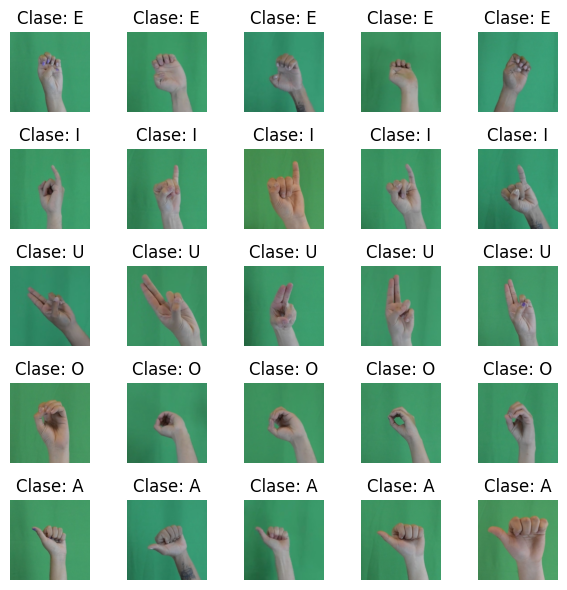

In [ ]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directorio que contiene las carpetas de clases
data_dir = "vowels-dataset"  # Reemplaza con la ruta correcta

# Obtener la lista de carpetas (una por cada clase)
classes = os.listdir(data_dir)

# Crear una cuadrícula de subplots para mostrar ejemplos de cada clase
fig, axs = plt.subplots(len(classes), 5, figsize=(6, 6))

# Recorrer las clases y sus carpetas correspondientes
for i, class_name in enumerate(classes):

    # Construir la ruta completa a la carpeta de la clase
    class_dir = os.path.join(data_dir, class_name)

    # Obtener una lista de nombres de imágenes en la carpeta y tomar las primeras 5
    images = os.listdir(class_dir)[:5]

    # Recorrer las imágenes de la clase actual
    for j, image_name in enumerate(images):

        # Construir la ruta completa a la imagen
        image_path = os.path.join(class_dir, image_name)

        # Leer la imagen y mostrarla en el subplot correspondiente
        img = mpimg.imread(image_path)
        axs[i, j].imshow(img)

        # Establecer el título del subplot con el nombre de la clase
        axs[i, j].set_title(f"Clase: {class_name}")

        # Desactivar los ejes para una presentación más limpia
        axs[i, j].axis('off')

# Ajustar el diseño de los subplots para una presentación ordenada
plt.tight_layout()

# Mostrar la figura con las imágenes
plt.show()


# 3 **Data preparation**

## Detección de las manos

Para poder clasificar las imágenes de las vocales es necesario detectar las manos en primer lugar, para ello se usa la librería *CVZone*, con la cual se aplican funciones de detección.

Cuando se detecta una mano en la imagen devuelve una lista de los puntos de referencia (*landmarks*) de la mano detectada, de no ser así devuelve *None*.


In [ ]:
# Importar el módulo de cvzone para la detección de manos
from cvzone.HandTrackingModule import HandDetector

# Crear un objeto detector de manos con parámetros de detección personalizados
detector = HandDetector(detectionCon=0.8, maxHands=1)

# Función para convertir una imagen en una lista de landmarks (puntos de referencia)
def img_to_landmarks(img):

    # Utilizar el detector de manos para encontrar manos en la imagen
    hands = detector.findHands(img, draw=True)

    # hands es una tupla donde:
      # - El primer elemento es una lista con las manos detectadas
      # - El segundo elemento es la imagen original con las coordenadas superpuestas

    # Si no se detectan manos, retornar None
    if hands[0] == []:
        return None

    # Obtener los datos de la primera mano detectada (mano en el índice 0)
    hand = hands[0][0]

    # Obtener la lista de landmarks (puntos de referencia) de la mano
    lmList = hand["lmList"]

    return lmList  # Retornar la lista de landmarks de la mano detectada


## ¿Qué detectamos?

Los puntos representativos de una mano son como marcadores especiales en una imagen o video de una mano que se usan para enseñar a una computadora a entender los gesto[texto del vínculo](https://)s de la mano. Estos puntos ayudan a la computadora a saber dónde están los dedos y la mano, lo que es útil para tareas como reconocer gestos o seguir el movimiento de la mano.

Estos puntos serán establecidos para cada una de las imágenes de nuestro conjunto de datos.

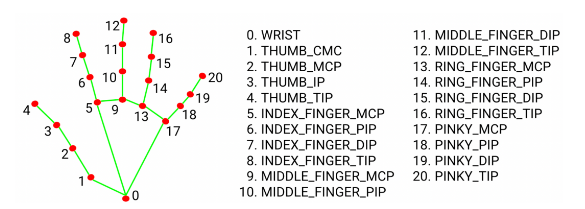

## Detección en cadena

Ahora que sabemos que podemos detectar las manos y extraer sus puntos de referencias de cada imagen, lo aplicaremos para todo nuestro conjunto de datos de imágenes de vocales.

Donde guardaremos en una lista **x** los puntos de referencia y en la lista **y** las etiquetas de cada clase.

Para esta sección se importa la librería **cv2** para procesar las imágenes.

In [ ]:
# Importar la biblioteca cv2 para procesar imágenes
import cv2
# Importar la bibiloteca os para recorrer los directorios
import os

# Ruta al directorio que contiene las carpetas de clases
DATASET_PATH = "vowels-dataset"

# Listas para almacenar datos de entrada (x) y etiquetas (y)
x = []  # Aquí almacenaremos los datos de entrada (listas de landmarks)
y = []  # Aquí almacenaremos las etiquetas de clase

# Recorrer cada carpeta de clase en el directorio del dataset
for label in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label)

    # Recorrer cada archivo dentro de la carpeta de la clase
    for file in os.listdir(label_path):
        file_path = os.path.join(label_path, file)

        # Leer la imagen utilizando OpenCV
        img = cv2.imread(file_path)

        # Procesar la imagen para obtener landmarks (asegúrate de que esta función esté definida)
        lmList = img_to_landmarks(img)

        if lmList is None:
            continue

        # Agregar la lista de landmarks a x y la etiqueta de clase a y
        x.append(lmList)
        y.append(label)


## Lo que detectamos sobre los datos originales
Para comprender lo que se hizo anteriormente, visualizaremos como se ven las manos y los puntos de referencia que fueron extraídos de las imágenes.

Gracias a la ayuda de **matplotlib** y **cv2** podemos completar la meta deseada.

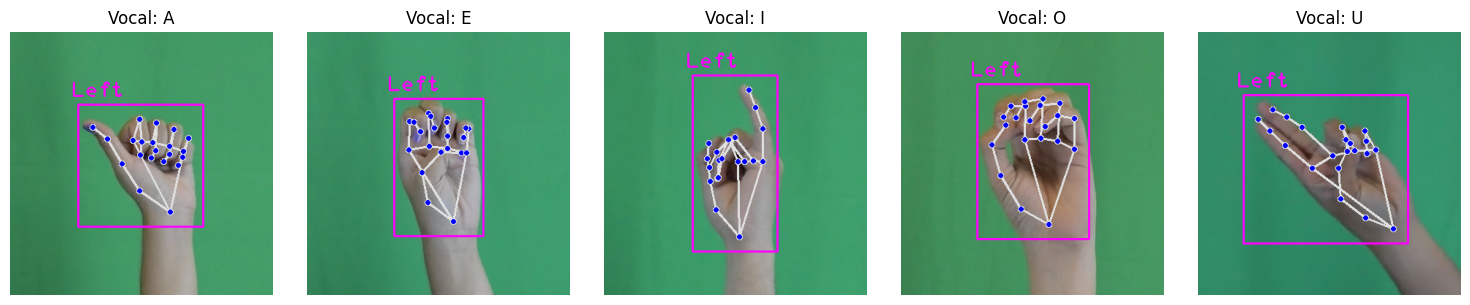

In [ ]:
# Lista de las vocales
vowels = ["A", "E", "I", "O", "U"]

# Creación de plot que contenga 5 subplots
fig, axs = plt.subplots(1, len(vowels), figsize=(15, 3))

# Iterar sobre las vocales para incluirlas en el plot
for i, vowel in enumerate(vowels):

    # Navegar hacia la carpeta de la vocal correspondiente y tomar la primera imagen
    folder_path = os.path.join("/content/vowels-dataset", vowel)
    image_name = os.listdir(folder_path)[0]
    image_path = os.path.join(folder_path, image_name)

    # Lectura y procesamiento de la imagen
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lmList = img_to_landmarks(img_rgb)

    # Plottear la imagen
    axs[i].imshow(img_rgb)
    axs[i].set_title(f"Vocal: {vowel.upper()}")
    axs[i].axis('off')

# Mostrar la imagen
plt.tight_layout()
plt.show()

#Distribución por clase
Ya que se han etiquetado todas las imáganes que tenemos, podemos observar la distribución de las clases, para verificar como es que nuestro conjunto de datos fue detectado y etiquetado.

Para ello haremos un histograma con la ayuda de **matplotlib**, mostrando el gráfico con la distribución de los resultados para cada vocal.



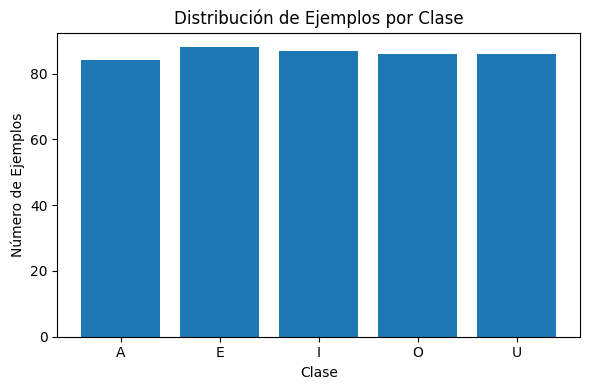

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener las clases únicas presentes en las etiquetas
unique_classes = np.unique(y)

# Calcular el número de ejemplos por clase
class_counts = [y.count(cls) for cls in unique_classes]

# Crear un gráfico de barras para mostrar la distribución
plt.figure(figsize=(6, 4))
plt.bar(unique_classes, class_counts)
plt.xlabel("Clase")
plt.ylabel("Número de Ejemplos")
plt.title("Distribución de Ejemplos por Clase")
plt.xticks(unique_classes)  # Asegurar que las etiquetas en el eje x sean las clases únicas
plt.tight_layout()
plt.show()

## Escalamiento y aplanamiento de los datos

Para poder usar estas imágenes etiquetadas para nuestro modelo de predicción es necesario aplicarles ciertas transformaciones para que el proceso sea más sencillo y rápido.

Con el fin de realizar este objetivo usaremos la librería **sklearn** pues es una herramienta poderosa que simplifica el proceso de construir, entrenar y evaluar modelos de machine learning.

En este caso usaremos la función MinMaxScaler que mantiene a los valores entre un rango específico, en este caso entre 0 y 1.

Al mismo tiempo convertiremos nuestro arreglo de varias dimensiones a un arreglo de una sola dimensión, esto nos permite hacer operaciones al arreglo de una manera más sencilla.




In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Crear una lista para almacenar los datos procesados
X_processed = []

for element in x:
    # Crear un objeto MinMaxScaler
    scaler = MinMaxScaler()

    # Escalar los datos en x_array
    x_scaled = scaler.fit_transform(element)

    # Aplanar la matriz en un vector
    x_flattened = x_scaled.flatten()

    # Agregar el vector procesado a la lista processed_x
    X_processed.append(x_flattened)
print(X_processed)

[array([0.75949367, 1.        , 0.77272727, 0.34177215, 0.85443038,
       0.34090909, 0.20253165, 0.60759494, 0.25      , 0.46835443,
       0.41772152, 0.18181818, 0.75949367, 0.34810127, 0.15909091,
       0.03797468, 0.32911392, 0.93181818, 0.        , 0.07594937,
       0.59090909, 0.08860759, 0.05696203, 0.20454545, 0.18987342,
       0.16455696, 0.        , 0.36708861, 0.30379747, 1.        ,
       0.30379747, 0.00632911, 0.72727273, 0.37974684, 0.        ,
       0.29545455, 0.44303797, 0.11392405, 0.04545455, 0.67088608,
       0.32911392, 0.97727273, 0.64556962, 0.05696203, 0.68181818,
       0.6835443 , 0.05063291, 0.29545455, 0.70886076, 0.1835443 ,
       0.11363636, 0.98734177, 0.37974684, 0.90909091, 1.        ,
       0.17088608, 0.61363636, 0.97468354, 0.14556962, 0.36363636,
       0.94936709, 0.23417722, 0.22727273]), array([1.        , 0.97333333, 1.        , 0.60185185, 1.        ,
       0.62264151, 0.18518519, 0.88666667, 0.41509434, 0.06481481,
       0.68     

# 4. **Modeling** and 5. **Evaluation**

## Evaluación interna

El entrenamiento es una etapa en la cual se le dan datos de ejemplo con las respuestas correctas al modelo, para que las aprenda y entienda los patrones de los datos.

En la validación pondremos a prueba al modelo que tan bien aprendió estos patrones, en este caso las imágenes de las manos haciendo las vocales en lenguaje de señas, para validarlo podemos mostrarle una nueva imagen y que determine que vocal es.

Para concretar esta tarea usaremos de nuevo la librería **sklearn**.

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
import numpy as np

# Configurar la validación Leave-One-Out
leave_one_out = LeaveOneOut()

# Listas para almacenar las etiquetas predichas y reales
predicted_labels_list = []
true_labels_list = []

# Convertir X_processed y y en arreglos numpy (necesario para crear las particiones de datos)
X_processed = np.array(X_processed)
y = np.array(y)

# Iterar a través de las particiones Leave-One-Out
for train_index, test_index in leave_one_out.split(X_processed, y):
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, y_train = X_processed[train_index], y[train_index]
    X_test, y_test = X_processed[test_index], y[test_index]



    # Inicializar y entrenar el clasificador SVM
    clf = SVC(kernel='poly', degree=3)
    clf.fit(X_train, y_train)

    # Predecir las etiquetas del conjunto de prueba
    predicted_labels = clf.predict(X_test)

    # Agregar las etiquetas predichas y reales a las listas
    predicted_labels_list.extend(predicted_labels)
    true_labels_list.extend(y_test)
print(predicted_labels_list)

['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'O', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'O', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'E', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U',

### Resultados

Para finalizar, podemos observar los resultados de nuestro modelo en una matriz de confusión la cual nos dice que resultados obtuvo en la validación nuestro modelo.

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        84
           E       0.95      0.94      0.95        88
           I       0.99      0.97      0.98        87
           O       0.92      0.98      0.95        86
           U       1.00      0.98      0.99        86

    accuracy                           0.97       431
   macro avg       0.97      0.97      0.97       431
weighted avg       0.97      0.97      0.97       431



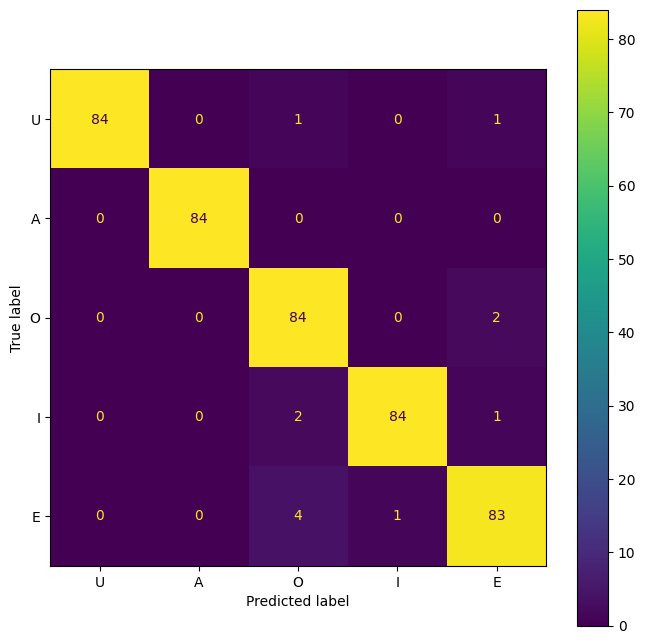

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

labels = list(set(y))
cm = confusion_matrix(true_labels_list, predicted_labels_list, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
print(classification_report(true_labels_list, predicted_labels_list))


###Intepretación: ¿dónde se confundió?
Visualizar los errores de un modelo de machine learning significa observar dónde se equivoca y por qué. Esto te ayuda a entender sus debilidades, mejorar su precisión y tomar decisiones más inteligentes.

Primero debemos encontrar aquellas imágenes que fueron mal clasificadas y mostrar cual es su verdadera etiqueta, para concretar nuestro propósito, usaremos las herramientas de visualización de **cv2** y **matplotlib**.

In [ ]:
# Definidmos la lista que contendrá los índices que fueron mal clasificados
mismatched_indices = []
label_index = 0

# Ciclo que toma cada letra de las etiquetas reales de las imágenes
for letter in true_labels_list:
  # Revisar si es que la letra clasificada es distinta a la verdadera
  if letter != predicted_labels_list[label_index]:
    # Añadir este elemento a la lista
    mismatched_indices.append(label_index)
  label_index += 1

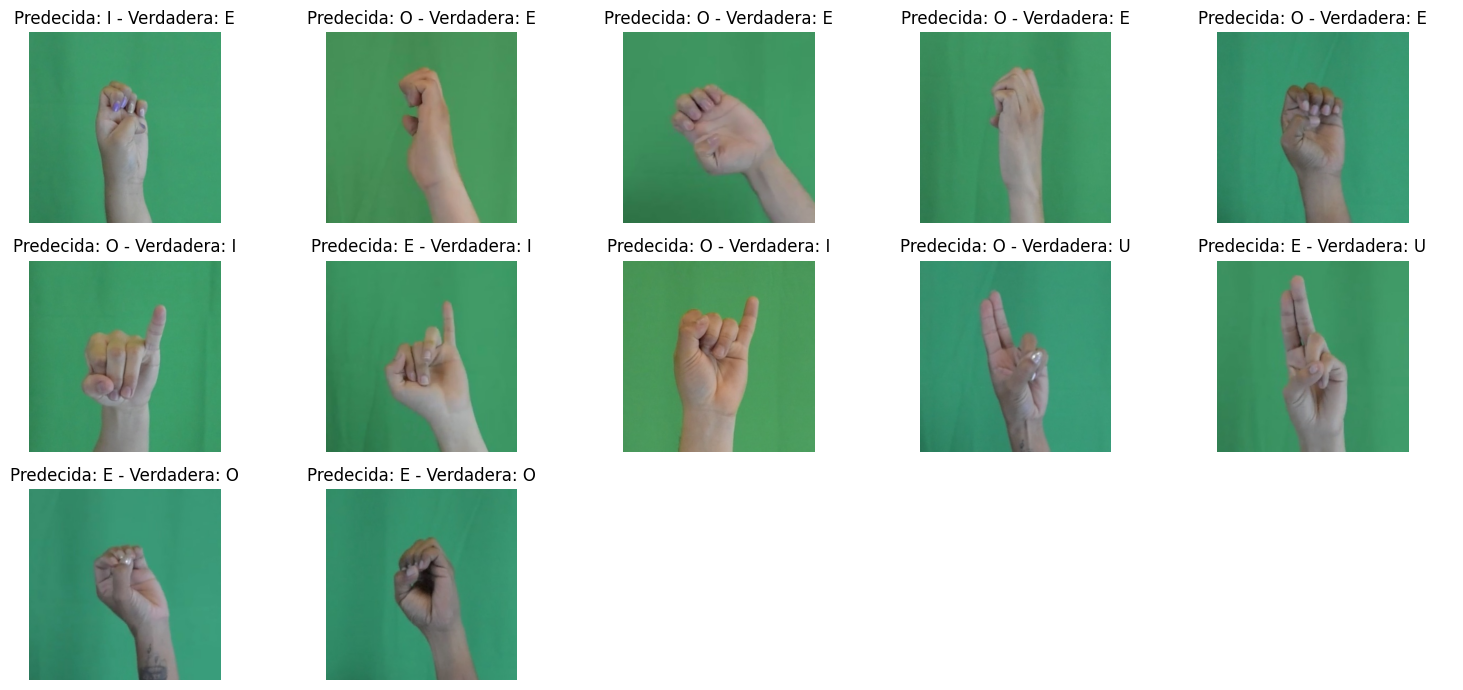

In [ ]:
# Definición del tamaño de la gráfica acorde a la cantidad de imágenes mal clasificadas
fig, axs = plt.subplots(math.ceil(len(mismatched_indices)/5), 5, figsize=(15, 7))

# Definición de índices de los archivos en el dataset y de la gráfica
file_index = 0
plot_position = 0
plot_row = 0
# Navegar entre las carpetas (Clases/Vocales) del dataset
for label in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label)

    # Recorrer cada archivo dentro de la carpeta de la clase
    for file in os.listdir(label_path):
        file_path = os.path.join(label_path, file)

        # Encontrar el nombre del archivo, cargarlo a la gráfica y aumentar el contador
        if file_index in mismatched_indices:
          plot_row = plot_position // 5
          plot_column = plot_position % 5
          img = cv2.imread("/content/" + file_path)
          img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          axs[plot_row, plot_position % 5].imshow(img_rgb)
          # Colocar como título la vocal predecida y la verdadera acorde al clasificador
          axs[plot_row, plot_position % 5].set_title(f"Predecida: {predicted_labels_list[file_index].upper()} - Verdadera: {true_labels_list[file_index].upper()}")
          axs[plot_row, plot_position % 5].axis('off')
          plot_position+=1
        file_index+=1

# Iterar sobre las posiciones restantes de la matriz para remover los ejes
for i in range(math.ceil(len(mismatched_indices) / 5)):
    for j in range(5):
        if i * 5 + j >= len(mismatched_indices):
            axs[i, j].axis('off')
# Imprimir la gráfica
plt.tight_layout()
plt.show()

# Evaluación externa

### Captura de nueva instancia de prueba

Esta sección es para tomar una foto de la cámara web, después la guarda en un archivo y finalmente la muestra.

<IPython.core.display.Javascript object>

Saved to photo.jpg


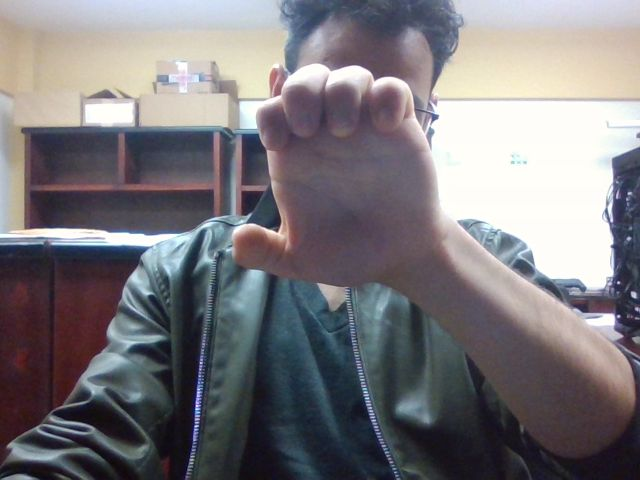

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Predicción sobre la nueva instancia

Para finalizar este **notebook**, cargaremos la imagen recién tomada y la evaluaremos con el modelo que generamos.


Con el fin de lograr este objetivo, primero debemos cargar la foto tomada y aplicarle el mismo proceso que se hizo anteriormente a todo el conjunto, comenzando por obtener los puntos de referencia.

Al mismo tiempo, le proporcionaremos al programa la vocal que se encuentra en la foto, para que el modelo pueda comparar si lo hace correctamente


¿Que vocal estas haciendo?: e
¡Excelente! Has ingresado una vocal.


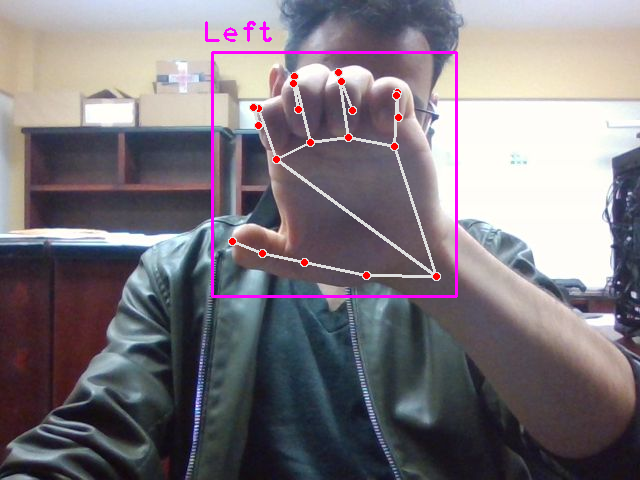

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

feature_vector = []
# Se toma la foto capturada y se solicita la vocal que se está utilizando
img_predict = cv2.imread("photo.jpg")
while True:

  label_predict = input("¿Que vocal estas haciendo?: ").upper()
  # Condición para sanitizar la entrada de datos
  if label_predict in 'AEIOU':
    print("¡Excelente! Has ingresado una vocal.")
    break
  else:
    print("Eso no es una vocal. Por favor, ingresa una vocal válida.")

# Realizamos el mismo proceso que se llevó a cabo para las otras imágenes, en el que se obtienen los landmarks de la mano
land_marks = img_to_landmarks(img_predict)
cv2_imshow(img_predict)
feature_vector.append(land_marks)

###Aplanar y escalar la foto

El siguiente paso es aplicarle el aplanamiento y escalamiento a la imagen que estamos tratando de darle al modelo. Tal como lo hicimos anteriormente para todo el conjunto de datos.

In [ ]:
X_processed = []
# Se realiza el proceso de aplanamiento y extensión de los datos realizado previamente
for element in feature_vector:
      # Crear un objeto MinMaxScaler
    scaler = MinMaxScaler()

    # Escalar los datos en x_array
    x_scaled = scaler.fit_transform(element)

    # Aplanar la matriz en un vector
    x_flattened = x_scaled.flatten()

    # Agregar el vector procesado a la lista processed_x
    X_processed.append(x_flattened)

X_processed = np.array(X_processed)
y = np.array(y)

img_predicted = clf.predict(X_processed)

###Mostrar la predicción

Finalmente, mostramos la imagen y la etiqueta de la vocal que predijo el modelo que generamos.

Inténtalo para varias imágenes y distintas vocales, es normal esperar algunos errores con algunas señales que se parezcan a otras.

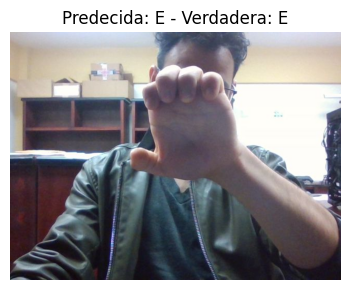

In [ ]:
#mostrar el predict

# Preparamos la imagen para ser mostrada con su predicción mediante el modelo de aprendizaje
fig, axs = plt.subplots(figsize=(15, 3))

# Cargamos la imagen y la transformamos al formato correcto para ser mostrado
image_path = ("/content/photo.jpg")
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
axs.imshow(img_rgb)
axs.set_title(f"Predecida: {img_predicted[0]} - Verdadera: {label_predict}")
axs.axis('off')

plt.tight_layout()
plt.show()